In [ ]:
pip install 'monai[all]'

     |████████████████████████████████| 584 kB 8.1 MB/s 
     |████████████████████████████████| 2.9 MB 38.2 MB/s 
     |████████████████████████████████| 221 kB 51.8 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 316 kB 42.2 MB/s 
     |████████████████████████████████| 50.1 MB 81 kB/s 
     |████████████████████████████████| 14.4 MB 30.3 MB/s 
     |████████████████████████████████| 10.3 MB 22.3 MB/s 
     |████████████████████████████████| 68.0 MB 56 kB/s 
     |████████████████████████████████| 14.0 MB 19.3 MB/s 
     |████████████████████████████████| 36.3 MB 1.5 MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27705 sha256=b93858dd5493266564b58f808437755478d27669c3b48e2efd8dd4486bf2430a
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python
  Attempting uninstall: tqdm
    Found e

In [ ]:
import monai
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torchvision
import logging
import numpy as np
import pickle
import os
import sys
import joblib
import json
import tempfile
import matplotlib.pyplot as plt

from scipy.special import softmax
from torch.nn import Module
from torch import sigmoid
from sklearn.model_selection import KFold
from sklearn import preprocessing
from monai.data import CacheDataset, DataLoader, Dataset, list_data_collate, ImageDataset, ITKReader, ArrayDataset
from monai.transforms import LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD, Activations, Resize
from monai.networks.layers import Norm
from monai.networks.nets import UNet, BasicUNet, VNet
from monai.losses import DiceLoss
from monai.engines import SupervisedTrainer, Trainer, SupervisedEvaluator
from torch.utils.data import DataLoader
from monai.inferers import sliding_window_inference
from monai.handlers import StatsHandler, MeanDice
from monai.transforms.utils import allow_missing_keys_mode
from keras.models import model_from_json, Model
from monai.metrics import DiceMetric
from monai.utils import set_determinism, first
from monai.metrics import compute_meandice
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
from torch.autograd import Variable
from monai.networks import one_hot

from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    ScaleIntensityd,
    RandRotate90d,
    MeanEnsemble
)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=92973d4efb832c76896eea674a446802eb70c0bb3ebe48645b5ed37235d98f55
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
cd gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021/ 

/content/gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021


In [ ]:
import import_ipynb
from KFoldFunction import kFoldSplit

importing Jupyter notebook from KFoldFunction.ipynb


In [ ]:
img_list = []

In [ ]:
folder_list = []

In [ ]:
directory_main = "/content/gdrive/My Drive/Echocardiography_ML_Project_Summer_2021"

In [ ]:
directory = "/content/gdrive/My Drive/CAMUS/training"

seg_count = 0
img_count = 0

for folder in os.listdir(directory):
  file_path = directory + '/' + folder
  
  folder_list.append(file_path)
  
  #for file in os.listdir(file_path):

    #if ".mhd" in file and "gt" not in file and "2CH" not in file and "sequence" not in file:
      #file_img = file_path + '/' + file
      #file_path + '/' + file
      
      #print(file_img)
      #img_list.append(file_img)

      #file_img = ''
      #img_count += 1

In [ ]:
fold = kFoldSplit(folder_list,1)
print(len(fold['test']),len(fold['train']),len(fold['validation']))

45 360 45


In [ ]:
train_set_patients = fold['train']
val_set_patients = fold['validation']

In [ ]:
train_set = []
val_set = []

In [ ]:
for patient in train_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      train_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [ ]:
for patient in val_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      val_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [ ]:
train_seg_list = [""]*len(train_set)

for i in range(len(train_set)):
  str = (train_set[i])[0:len(train_set[i])-4] + "_gt.mhd"
  train_seg_list[i] = str

val_seg_list = [""]*len(val_set)

for i in range(len(val_set)):
  str = (val_set[i])[0:len(val_set[i])-4] + "_gt.mhd"
  val_seg_list[i] = str

In [ ]:
train_list_data = [{}]*len(train_set)

for i in range(len(train_set)):
  img_label_dict = {'image':train_set[i],'label':train_seg_list[i]}
  
  train_list_data[i] = img_label_dict

In [ ]:
val_list_data = [{}]*len(val_set)

for i in range(len(val_set)):
  img_label_dict = {'image':val_set[i],'label':val_seg_list[i]}
  
  val_list_data[i] = img_label_dict

In [ ]:
train_list_data_truncated = [{}]*30
val_list_data_truncated = [{}]*30

for i in range(0,30):
  train_list_data_truncated[i] = (train_list_data[i])
  val_list_data_truncated[i] = (val_list_data[i])

In [ ]:
keys = ['image','label']

transforms = Compose(
    [
     LoadImageD(keys),
     ResizeD(keys,[256,256]),
     ToTensorD(keys)
    ]
)
#try larger batch size
batch_size = 16
num_workers = 4

In [ ]:
ds = Dataset(train_list_data,transforms)
train_loader = DataLoader(ds,batch_size,num_workers)

val_ds = Dataset(val_list_data,transforms)
val_loader = DataLoader(val_ds,batch_size,num_workers)

In [ ]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,  
    out_channels=4,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,

).to(device)
loss_function = DiceLoss(to_onehot_y=True,softmax=True)#, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-3#, weight_decay=1e-5, amsgrad=True
)

In [ ]:
print('Trainable params: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Trainable params: 6496585


In [ ]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
post_label = AsDiscrete(to_onehot=True, n_classes=2)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)

for epoch in range(45):
  print("-" * 45)
  print(f"epoch {epoch + 1}/{45}")
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
    
      optimizer.zero_grad()
      
      outputs = model(inputs)
      #outputs = torch.nn.Sigmoid()(outputs)

      loss = loss_function(outputs, labels)
      loss.backward()

      optimizer.step()
      epoch_loss += loss.item()
      epoch_len = len(ds) // train_loader.batch_size
      print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
      writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
      model.eval()
      with torch.no_grad():
          metric_sum = 0.0
          metric_count = 0

          val_images = None
          val_labels = None
          val_outputs = None

          for val_data in val_loader:

              #print(val_data["image"])
              val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
              
              val_outputs = model(val_images)
              #print("after model",val_outputs.shape,val_outputs)

              val_outputs = torch.nn.Softmax(dim=1)(val_outputs)
              #print("after softmax",val_outputs.shape,val_outputs)

              val_outputs = torch.argmax(val_outputs,dim=1,keepdim=True)
              #print("after argmax",val_outputs.shape,val_outputs)

              #val_outputs = post_trans(val_outputs)
              val_outputs = one_hot(val_outputs,num_classes=4,dim=1)
              #print("after one hot",val_outputs.shape,val_outputs)

              #val_labels = post_trans_label(val_labels)
              val_labels = one_hot(val_labels,num_classes=4,dim=1)

              value = compute_meandice(
                y_pred=val_outputs,
                y=val_labels,
                include_background=True,
              )

              #print("value",value.shape,value)
              
              metric_count += len(value)
              metric_sum += value[:,1,...].sum() 
          metric = metric_sum / metric_count
          metric_values.append(metric)
          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              #torch.save(model.state_dict(), root_dir)
              model_name = 'best_segmentation_model_fold_2.pth'
              path = os.path.join(directory_main,model_name)
              torch.save(model.state_dict(),path)

              print("saved new best metric model")
          print(
              "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                  epoch + 1, metric, best_metric, best_metric_epoch
              )
          )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

---------------------------------------------
epoch 1/45
1/45, train_loss: 0.8155
2/45, train_loss: 0.8055
3/45, train_loss: 0.7976
4/45, train_loss: 0.8030
5/45, train_loss: 0.7871
6/45, train_loss: 0.7923
7/45, train_loss: 0.7799
8/45, train_loss: 0.7779
9/45, train_loss: 0.7639
10/45, train_loss: 0.7661
11/45, train_loss: 0.7610
12/45, train_loss: 0.7492
13/45, train_loss: 0.7389
14/45, train_loss: 0.7372
15/45, train_loss: 0.7352
16/45, train_loss: 0.7287
17/45, train_loss: 0.7305
18/45, train_loss: 0.7466
19/45, train_loss: 0.7305
20/45, train_loss: 0.7338
21/45, train_loss: 0.7323
22/45, train_loss: 0.7361
23/45, train_loss: 0.7317
24/45, train_loss: 0.7174
25/45, train_loss: 0.7079
26/45, train_loss: 0.7115
27/45, train_loss: 0.7105
28/45, train_loss: 0.7150
29/45, train_loss: 0.7097
30/45, train_loss: 0.7124
31/45, train_loss: 0.7069
32/45, train_loss: 0.6957
33/45, train_loss: 0.7115
34/45, train_loss: 0.6891
35/45, train_loss: 0.6982
36/45, train_loss: 0.6952
37/45, train_los

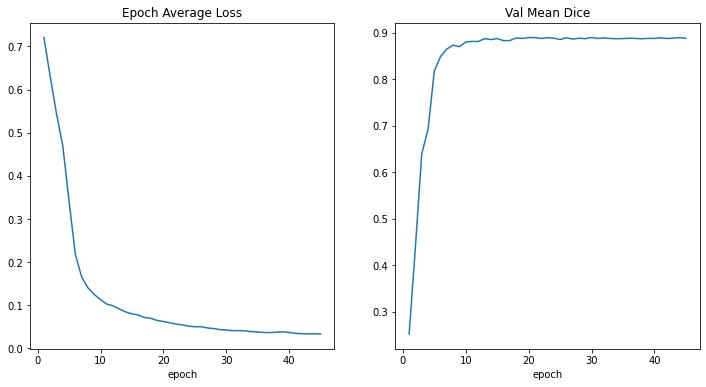

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()